# Single cell proteomics pipeline
#### **Author:** Gerard Font Juvanteny
_MBDS - Master Biomedical Data Science_


---
### Import required libraries


In [1]:
import pandas as pd
from src.data.dea import differential_expression_analysis
from src.string_client import StringClient

# Import PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from igraph import Graph, plot
from Bio import SeqIO
import os

from scipy.stats import ttest_ind


/Users/gerardfont/Documents/Gerard/Master_BiomedicalDataScience/00_Master_THESIS/code/pyMSpro/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


**Setup logs**

---
### Set parameters / constants


In [2]:
# Path to the data
PATH_DATA = './data/processed/2021_Leduc/'
NAME_EXPERIMENT = '2021_Leduc'


---
### Prepare data according the input format

In [3]:
# Load the data from the CSV file
prot_intensity = pd.read_csv(PATH_DATA + 'prot_proc.csv')
# Rename the first column to 'protein'
prot_intensity = prot_intensity.rename(columns={'Unnamed: 0': 'protein'})
# First column as the index
prot_intensity = prot_intensity.set_index('protein')
# Convert values to float
prot_intensity.apply(pd.to_numeric, errors='coerce')

# Load the data from the CSV file
metadata = pd.read_csv(PATH_DATA + 'anno.csv')
# Convert the first column to the index
metadata = metadata.set_index('Unnamed: 0')
# Replace the column names with the values of the first row
metadata.columns = metadata.iloc[0]
# Drop the first row from the metadata DataFrame
metadata = metadata.drop(metadata.index[0])


# Concatenate the metadata to the protein intensity data frame
# TODO: We assume that both data frames have the same order for the columns
prot_intensity = pd.concat([metadata, prot_intensity], axis=0, ignore_index=False)
print(prot_intensity.head())

                 i10      i102      i103      i104      i105      i106  \
celltype           H         U         U         U         H         H   
A0A024RBG1 -0.208326  0.317744   0.29467  0.381682 -0.187703 -0.267211   
A0A1B0GX78  0.195591 -0.122598 -0.627951  0.132455  0.153521  0.244738   
A0AVF1     -0.795366  0.114473  0.185542  0.258208 -0.260679  0.148852   
A1A4S6     -0.152512  0.060963  0.885153  0.314711 -0.345838 -0.549751   

                i107      i108      i109       i11  ...       i87       i88  \
celltype           H         H         H         H  ...         U         H   
A0A024RBG1 -0.103692 -0.264988  -0.35848 -0.366581  ...  0.542687 -0.493343   
A0A1B0GX78 -0.364624 -0.074277  0.251052  0.049257  ...  0.045749  0.271147   
A0AVF1      0.402998 -0.305016  0.323643 -0.425968  ... -0.032475  0.106257   
A1A4S6     -0.202808  0.021079 -0.307785  0.359791  ...  0.143857 -0.691573   

                 i89        i9       i90       i91       i92       i93  \
cellty



---
### Statistic analysis

**Number of single-cells samples and Number of proteins found**

In [4]:
print("Number of Single-cell samples:", prot_intensity.shape[1])
print("Number of Proteins:", prot_intensity.shape[0]-1)

Number of Single-cell samples: 163
Number of Proteins: 1647


**Plot protein intensities**

In [5]:
# Create another dataframe without the first row
prot_intensity_no_metadata = prot_intensity.iloc[1:, :]

# Finding the min value and its position
min_value = prot_intensity_no_metadata.min().min()
min_position = prot_intensity_no_metadata.stack().idxmin()

# Finding the max value and its position
max_value = prot_intensity_no_metadata.max().max()
max_position = prot_intensity_no_metadata.stack().idxmax()

print(f"Minimum value: {min_value} at position (row, column): {min_position}")
print(f"Maximum value: {max_value} at position (row, column): {max_position}")


Minimum value: -3.37626703921849 at position (row, column): ('Q13733', 'i231')
Maximum value: 3.63979305113291 at position (row, column): ('Q13519', 'i120')


In [6]:
prot_intensity_T = prot_intensity.T
prot_intensity_T = prot_intensity_T.drop(columns=['celltype'])
print(prot_intensity_T.head())


     A0A024RBG1 A0A1B0GX78    A0AVF1    A1A4S6    A4D0S4    A4FU69    A6H8Y1  \
i10   -0.208326   0.195591 -0.795366 -0.152512 -0.083936  0.262566 -0.330972   
i102   0.317744  -0.122598  0.114473  0.060963  0.287396  0.097426  0.579381   
i103    0.29467  -0.627951  0.185542  0.885153  0.297342  0.107372  0.727271   
i104   0.381682   0.132455  0.258208  0.314711  0.283589  0.093619  0.713518   
i105  -0.187703   0.153521 -0.260679 -0.345838 -0.184337 -0.025293 -0.327262   

        A6NFK2    A6NFN9    A6NGR9  ...    Q9Y5Q8    Q9Y5S9    Q9Y5W9  \
i10   0.684506  0.970011 -0.880989  ...  1.362794 -0.090204 -0.131163   
i102  1.443848  -0.99663  1.202588  ... -1.386451 -0.651874  0.216465   
i103  1.453794 -0.943628   -0.0521  ... -1.544113 -0.149517  0.226411   
i104  1.440041 -1.500282  0.624641  ... -1.390258 -0.456611  0.105575   
i105 -1.190058  0.060566  0.064436  ...  0.997089  0.340324 -0.119809   

        Q9Y613    Q9Y617    Q9Y653    Q9Y6C2    Q9Y6D6    Q9Y6V7    Q9Y6W6  
i10

In [7]:
# Split the dataframe by "celltype"
prot_intensity_U = prot_intensity.loc[:, prot_intensity.loc['celltype'] == 'U']
prot_intensity_H = prot_intensity.loc[:, prot_intensity.loc['celltype'] == 'H']

# Remove the row "celltype"
prot_intensity_U = prot_intensity_U.drop('celltype')
prot_intensity_H = prot_intensity_H.drop('celltype')

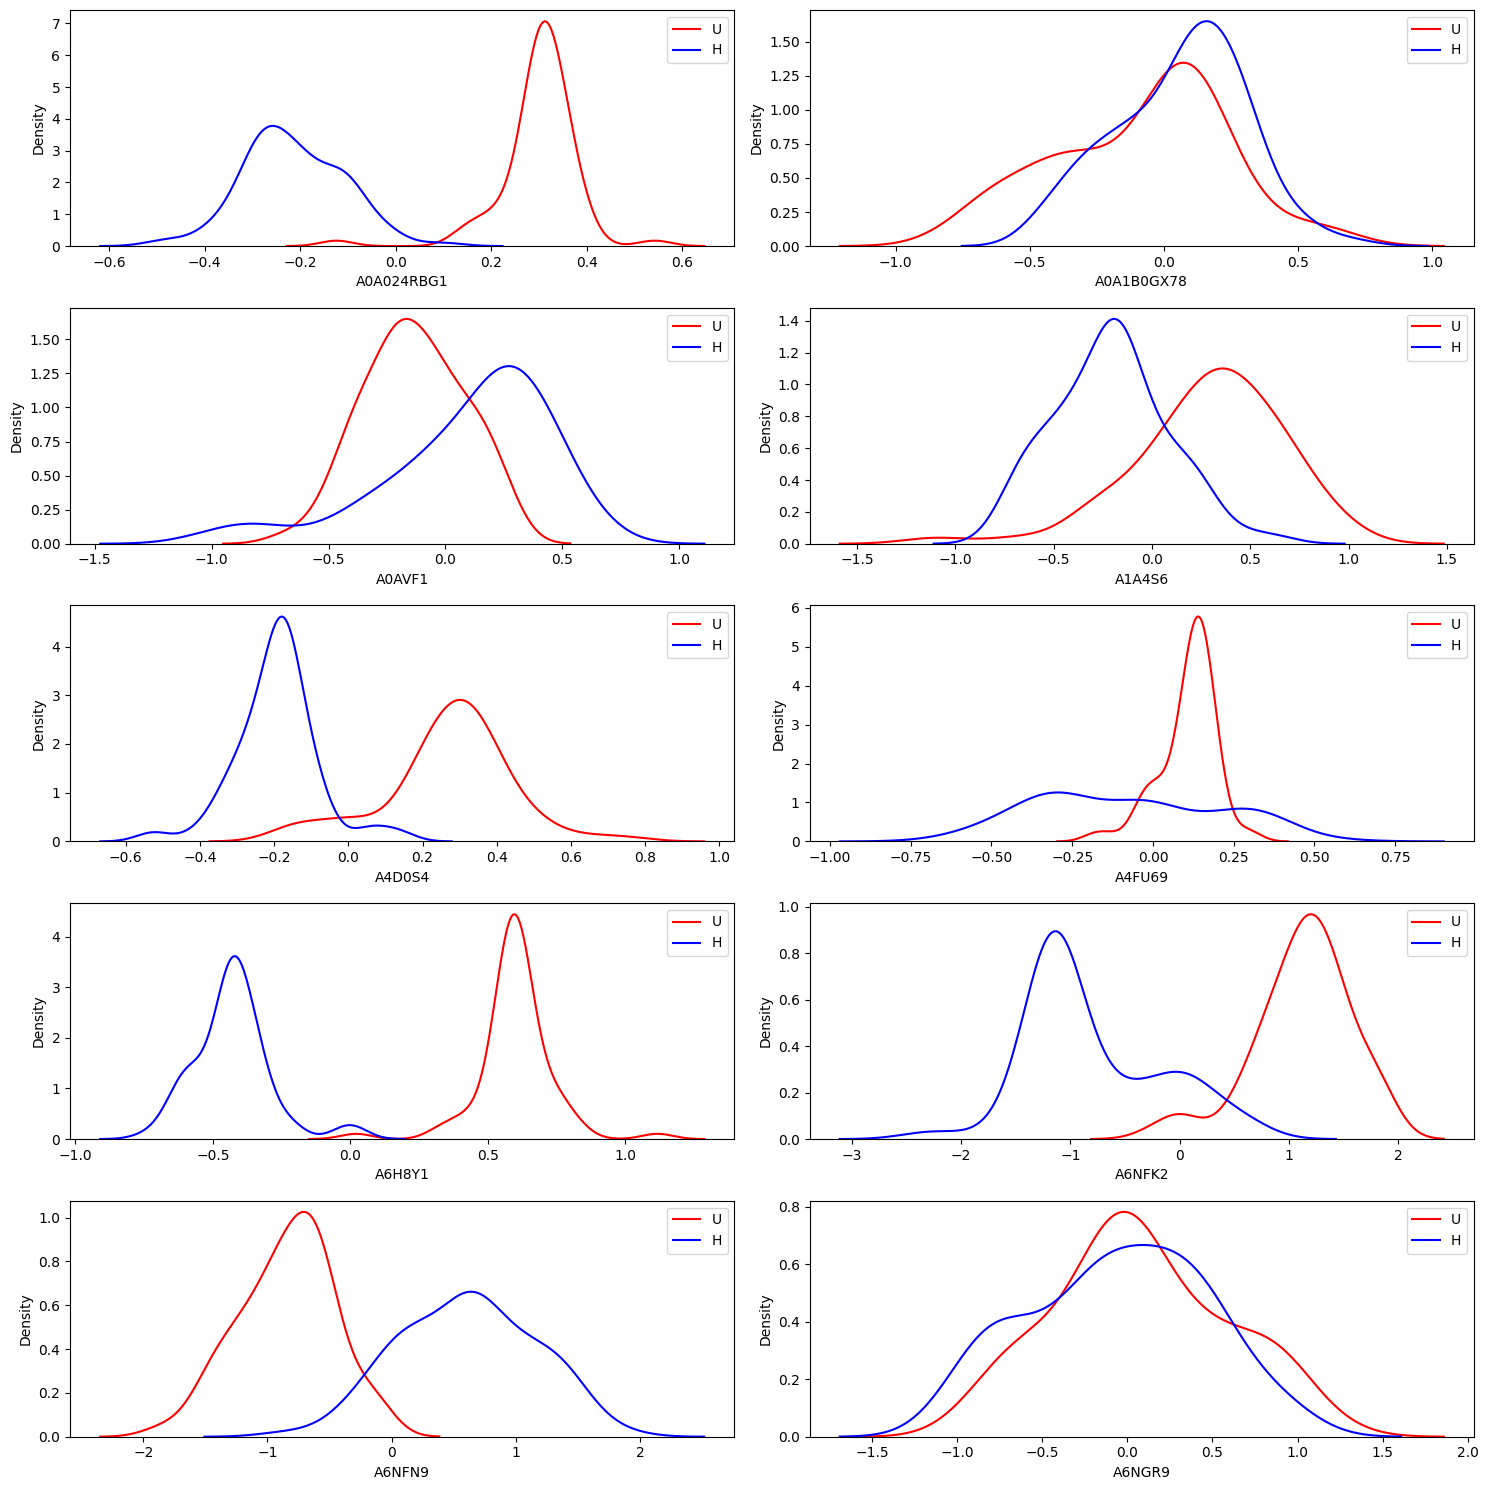

In [8]:
# Density plots of the first 10 proteins 
index = prot_intensity_U.index

fig, axs = plt.subplots(5, 2, figsize=(15, 15))

for i in range(0, 10, 2):
    sns.kdeplot(prot_intensity_U.loc[index[i], :], color='red', ax=axs[int(i/2), 0])
    sns.kdeplot(prot_intensity_H.loc[index[i], :], color='blue', ax=axs[int(i/2), 0])
    
    sns.kdeplot(prot_intensity_U.loc[index[i+1], :], color='red', ax=axs[int(i/2), 1])
    sns.kdeplot(prot_intensity_H.loc[index[i+1], :], color='blue', ax=axs[int(i/2), 1])

    axs[int(i/2), 0].legend(['U', 'H'])
    axs[int(i/2), 1].legend(['U', 'H'])

plt.tight_layout()
plt.show()

**Perform a PCA**

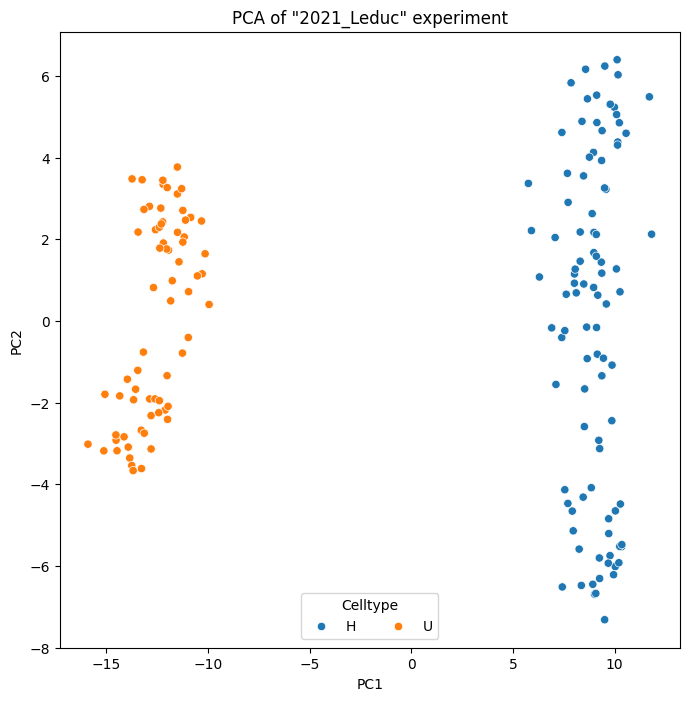

In [9]:
# Perform a PCA 
pca = PCA(n_components=2)

# Transpose the data
pca_data = prot_intensity.T

X = pca_data.iloc[:, 1:]
Y = pca_data.iloc[:, 0]

principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
principalDf.index = pca_data.index

# Concatenate the 1st row of prot_intensity to the principalDf
pca_df = pd.concat([principalDf , Y], axis=1)

# Plot the PCA and place the in the upper center, including the title "Celltype" for the lagend
plt.figure(figsize=(8, 8))
plt.title('PCA of "{0}" experiment'.format(NAME_EXPERIMENT))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='celltype')
plt.legend(title='Celltype', loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=3)
plt.show()



**Differential Expression Analysis**

**Independent (Two-sample) t-test**
Independent t-test to compare protein intensities between two different conditions (celltypes).

**Hypotheses**
* **Null hypothesis (𝐻0):** The means of the two groups are equal (no difference).
* **Alternative hypothesis (𝐻𝑎)**: The means of the two groups are not equal (there is a difference).

**Assumptions**

* The data is approximately normally distributed.
* The variances of the two groups are equal (homogeneity of variance).
* The samples are independent.


**Parameters for the t-test function**

* **Data_U**: Protein intensities from celltype U.
* **Data_H**: Protein intensities from celltype H.
* **Equal variance assumption**: Whether to assume equal variance between groups (equal_var parameter).

In [10]:
data_H = prot_intensity_H
data_U = prot_intensity_U

data_H = data_H.apply(pd.to_numeric, errors='coerce')
data_U = data_U.apply(pd.to_numeric, errors='coerce')

# Initialize lists to store results
proteins = index
t_stats = []
p_values = []

# Loop through each protein and perform a t-test
for protein in proteins:
    group1 = data_H.loc[protein].values
    group2 = data_U.loc[protein].values
    t_stat, p_val = ttest_ind(group1, group2, equal_var=True)
    t_stats.append(t_stat)
    p_values.append(p_val)

# Create a DataFrame to hold the results
results_df = pd.DataFrame({
    'Protein': proteins,
    'T-statistic': t_stats,
    'P-value': p_values
})

print(results_df)


         Protein  T-statistic       P-value
0     A0A024RBG1   -34.047661  1.830475e-75
1     A0A1B0GX78     3.309310  1.154076e-03
2         A0AVF1     4.681878  6.001528e-06
3         A1A4S6    -9.588347  1.660108e-17
4         A4D0S4   -21.242468  1.463226e-48
...          ...          ...           ...
1642      Q9Y653    -5.679437  6.165551e-08
1643      Q9Y6C2   -31.552515  7.841184e-71
1644      Q9Y6D6    11.769895  1.812358e-23
1645      Q9Y6V7     9.744773  6.314033e-18
1646      Q9Y6W6    -6.301361  2.708100e-09

[1647 rows x 3 columns]


In [11]:
# Count number of results with p-value < 0.05
significant_results = results_df[results_df['P-value'] < 0.05]
print(f"Number of significant results: {len(significant_results)}")

# Sort the results by p-value
sorted_results = results_df.sort_values(by='P-value')
print(sorted_results.head())


Number of significant results: 1314
     Protein  T-statistic        P-value
151   O75477  -121.704020  2.175712e-160
183   O94911   101.149498  1.275441e-147
1398  Q9BVC5    91.593196  8.450031e-141
1336  Q96KG7   -79.661969  2.988108e-131
1351  Q96PY5    75.234965  2.340141e-127


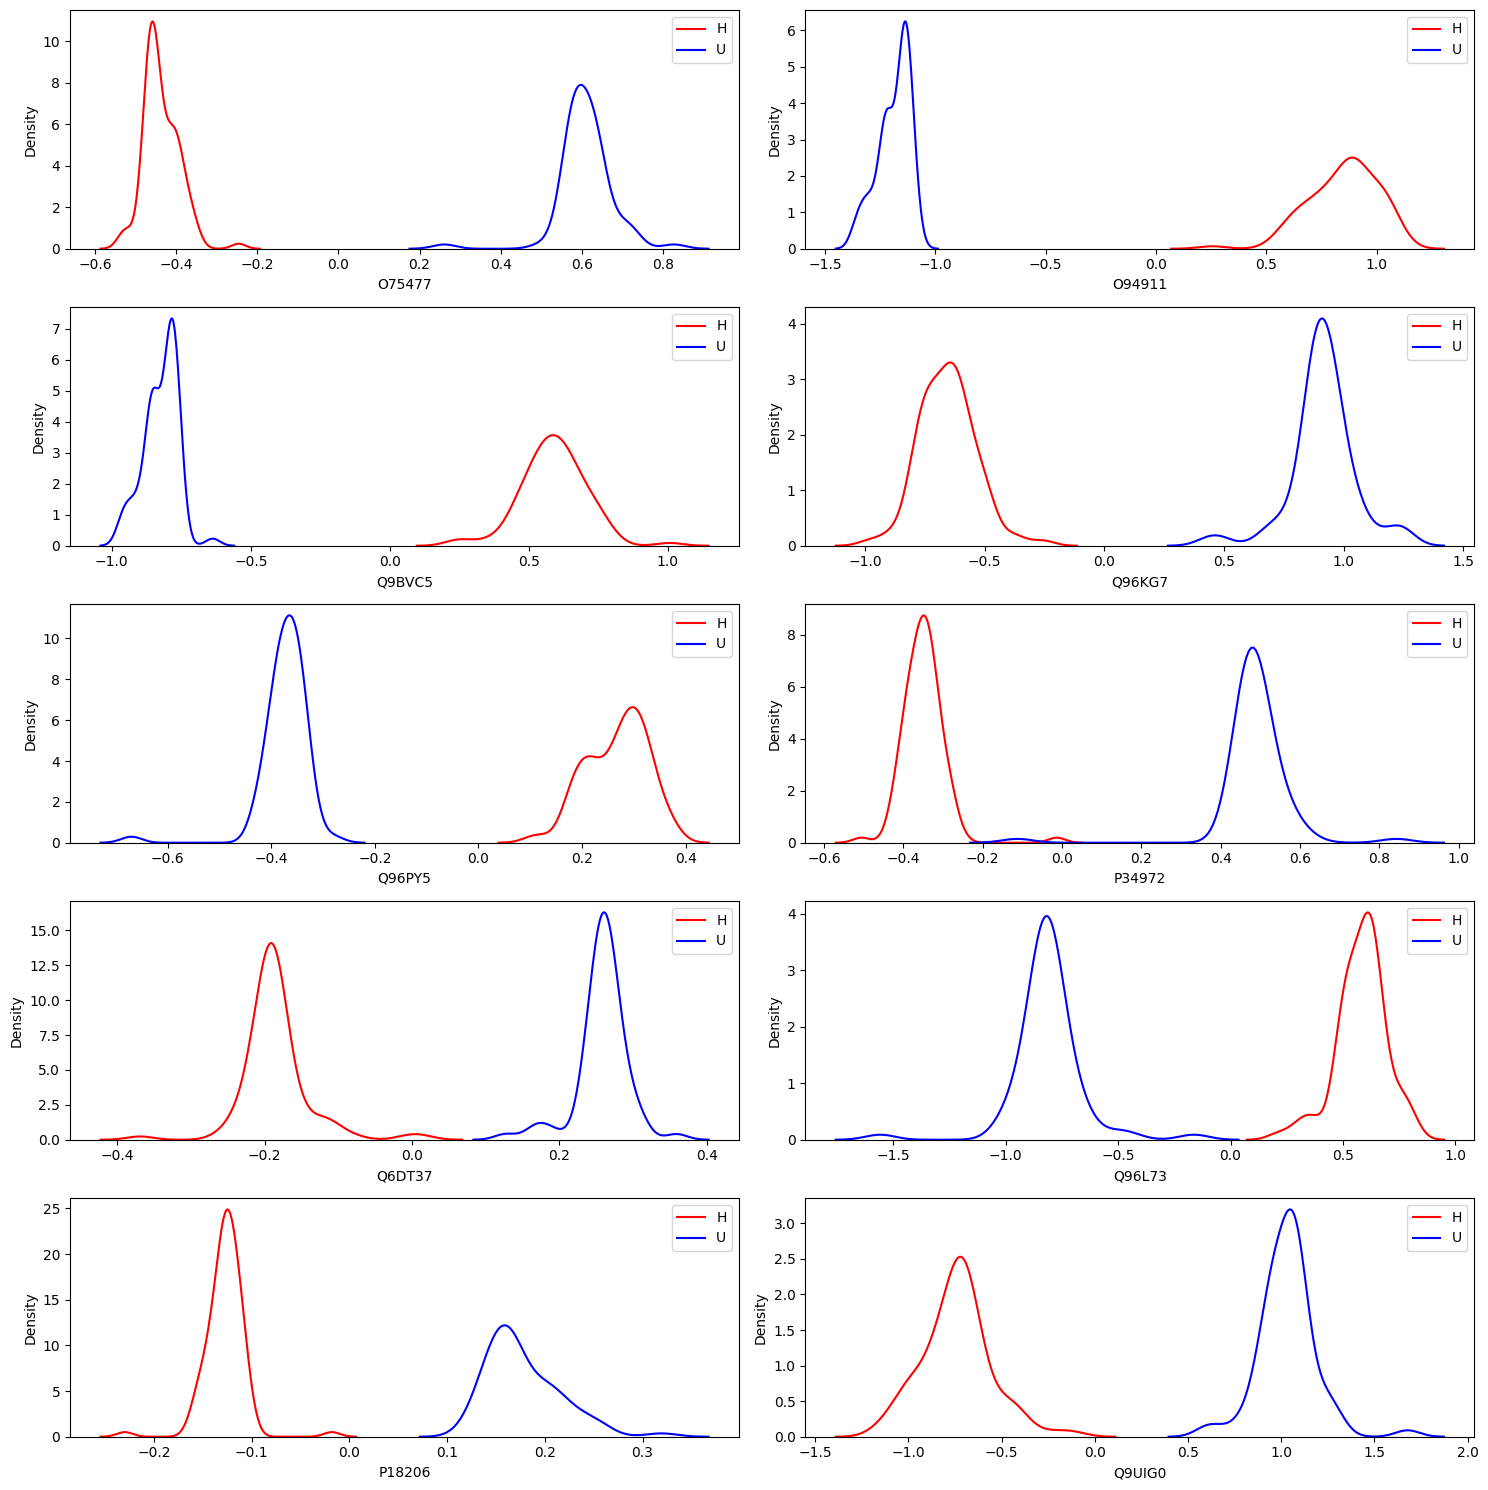

In [12]:
# Density plot of the top 10 proteins with the lowest p-values
fig, axs = plt.subplots(5, 2, figsize=(15, 15))

for i in range(0, 10, 2):
    sns.kdeplot(data_H.loc[sorted_results.iloc[i, 0], :], color='red', ax=axs[int(i/2), 0])
    sns.kdeplot(data_U.loc[sorted_results.iloc[i, 0], :], color='blue', ax=axs[int(i/2), 0])
    
    sns.kdeplot(data_H.loc[sorted_results.iloc[i+1, 0], :], color='red', ax=axs[int(i/2), 1])
    sns.kdeplot(data_U.loc[sorted_results.iloc[i+1, 0], :], color='blue', ax=axs[int(i/2), 1])

    axs[int(i/2), 0].legend(['H', 'U'])
    axs[int(i/2), 1].legend(['H', 'U'])

plt.tight_layout()
plt.show()



---
#### Functional Enrichment Analysis

**StringDB Client**

In [13]:
sdb = StringClient(server_url="https://string-db.org/api", species=9606, score_threshold=400)

In [14]:
# Functional Enrichment Analysis for the 10 most significant proteins
# Get the protein names
top10_proteins = sorted_results.iloc[:2, 0].values

# For each protein, get enriched terms
for protein in top10_proteins:
    functional = sdb.get_annotations(protein, "tsv")
    enrich = sdb.get_enrichment(protein, "json")
    page = sdb.get_protein_page(protein, "tsv")
    print(functional)
    print(enrich)
    print(page)
    print("\n")



category	term	number_of_genes	ratio_in_set	ncbiTaxonId	inputGenes	preferredNames	description
COMPARTMENTS	GOCC:0005622	1	1.0	9606	ERLIN1	ERLIN1	Intracellular
COMPARTMENTS	GOCC:0005737	1	1.0	9606	ERLIN1	ERLIN1	Cytoplasm
COMPARTMENTS	GOCC:0005783	1	1.0	9606	ERLIN1	ERLIN1	Endoplasmic reticulum
COMPARTMENTS	GOCC:0005789	1	1.0	9606	ERLIN1	ERLIN1	Endoplasmic reticulum membrane
COMPARTMENTS	GOCC:0012505	1	1.0	9606	ERLIN1	ERLIN1	Endomembrane system
COMPARTMENTS	GOCC:0016020	1	1.0	9606	ERLIN1	ERLIN1	Membrane
COMPARTMENTS	GOCC:0031090	1	1.0	9606	ERLIN1	ERLIN1	Organelle membrane
COMPARTMENTS	GOCC:0031984	1	1.0	9606	ERLIN1	ERLIN1	Organelle subcompartment
COMPARTMENTS	GOCC:0032991	1	1.0	9606	ERLIN1	ERLIN1	Protein-containing complex
COMPARTMENTS	GOCC:0042175	1	1.0	9606	ERLIN1	ERLIN1	Nuclear outer membrane-endoplasmic reticulum membrane network
COMPARTMENTS	GOCC:0043226	1	1.0	9606	ERLIN1	ERLIN1	Organelle
COMPARTMENTS	GOCC:0043227	1	1.0	9606	ERLIN1	ERLIN1	Membrane-bounded organelle
COMPARTMENTS	GOCC:0

In [15]:
# Get the top 50 proteins with the lowest p-values
top_proteins = sorted_results.iloc[:50, 0].values

# Get the STRING IDs for the top proteins
mapped_proteins = sdb.map_proteins(top_proteins, output_format="tsv-no-header")

# Parse the STRING interactions
interactions = []
for line in mapped_proteins.strip().split("\n"):
    parts = line.split("\t")
    if len(parts) >= 5:
        interactions.append((parts[0], parts[1], float(parts[5])))

mapped_proteins

TypeError: sequence item 0: expected str instance, numpy.ndarray found

In [ ]:
interactions

[('9606.ENSP00000211998', '9606.ENSP00000246069', 0.437),
 ('9606.ENSP00000220849', '9606.ENSP00000418695', 0.55),
 ('9606.ENSP00000220849', '9606.ENSP00000248342', 0.999),
 ('9606.ENSP00000231487', '9606.ENSP00000418695', 0.538),
 ('9606.ENSP00000232564', '9606.ENSP00000316244', 0.744),
 ('9606.ENSP00000248342', '9606.ENSP00000418695', 0.593),
 ('9606.ENSP00000343867', '9606.ENSP00000442047', 0.441),
 ('9606.ENSP00000343867', '9606.ENSP00000355228', 0.824),
 ('9606.ENSP00000351575', '9606.ENSP00000361180', 0.871),
 ('9606.ENSP00000355228', '9606.ENSP00000442047', 0.418),
 ('9606.ENSP00000358840', '9606.ENSP00000442047', 0.616),
 ('9606.ENSP00000368164', '9606.ENSP00000399851', 0.445),
 ('9606.ENSP00000395929', '9606.ENSP00000442047', 0.429)]

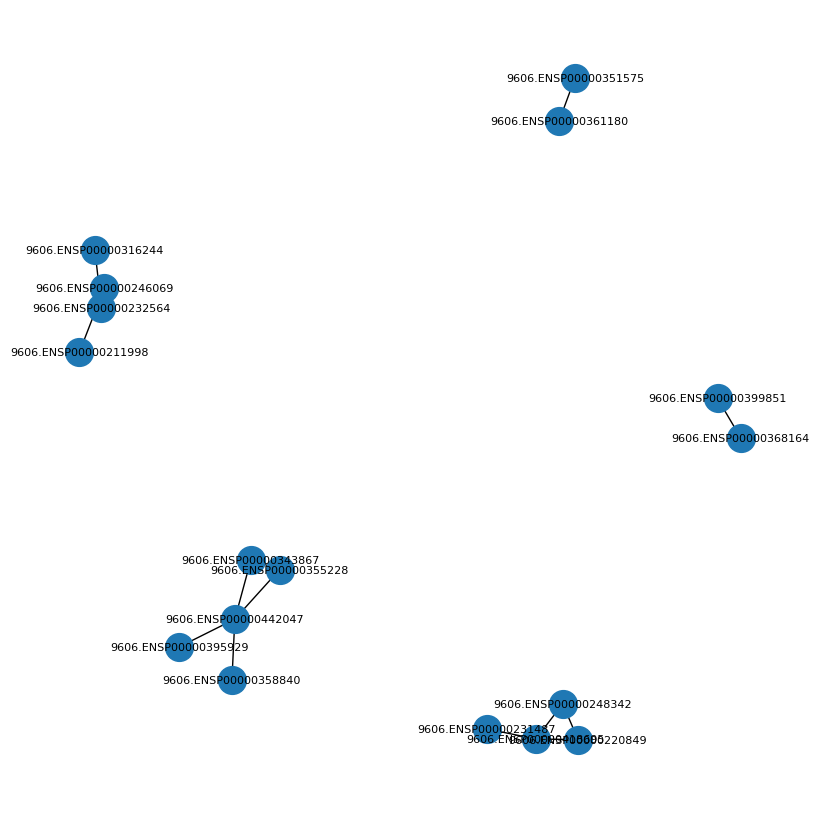

In [ ]:
# Create a network with the interactions
import networkx as nx
G = nx.Graph()
G.add_weighted_edges_from(interactions)


# Plot the network
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=400, width=1)
nx.draw_networkx_labels(G, pos, labels={n: n for n in G.nodes()}, font_size=8)
plt.show()

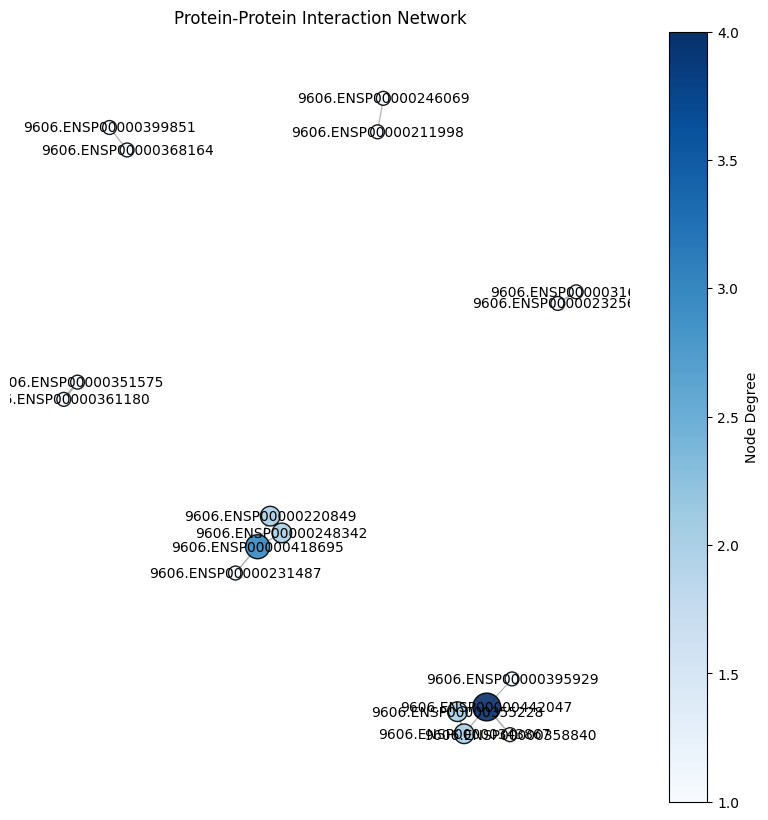

In [ ]:
# Create a networkx graph from the interactions
G = nx.Graph()
G.add_weighted_edges_from(interactions)

# Calculate degrees (number of connections) for node sizing and coloring
degree_dict = dict(G.degree(G.nodes()))
node_size = [v * 100 for v in degree_dict.values()]
node_color = [degree_dict[node] for node in G.nodes()]

# Get edge weights for line thickness
edge_width = [d['weight'] * 2 for (u, v, d) in G.edges(data=True)]

# Plot the network
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=0.15)  # k controls the distance between nodes

# Draw nodes with customized size and color
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.Blues, alpha=0.9)
nodes.set_edgecolor('black')  # Outline nodes in black

# Draw edges with customized width
edges = nx.draw_networkx_edges(G, pos, width=edge_width, alpha=0.6, edge_color='grey')

# Draw labels
labels = nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Add color bar for node degree
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(node_color), vmax=max(node_color)))
sm.set_array([])

# Create an axes for the colorbar
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Node Degree')

# Remove axes for better aesthetics
plt.axis('off')
plt.title('Protein-Protein Interaction Network')
plt.show()

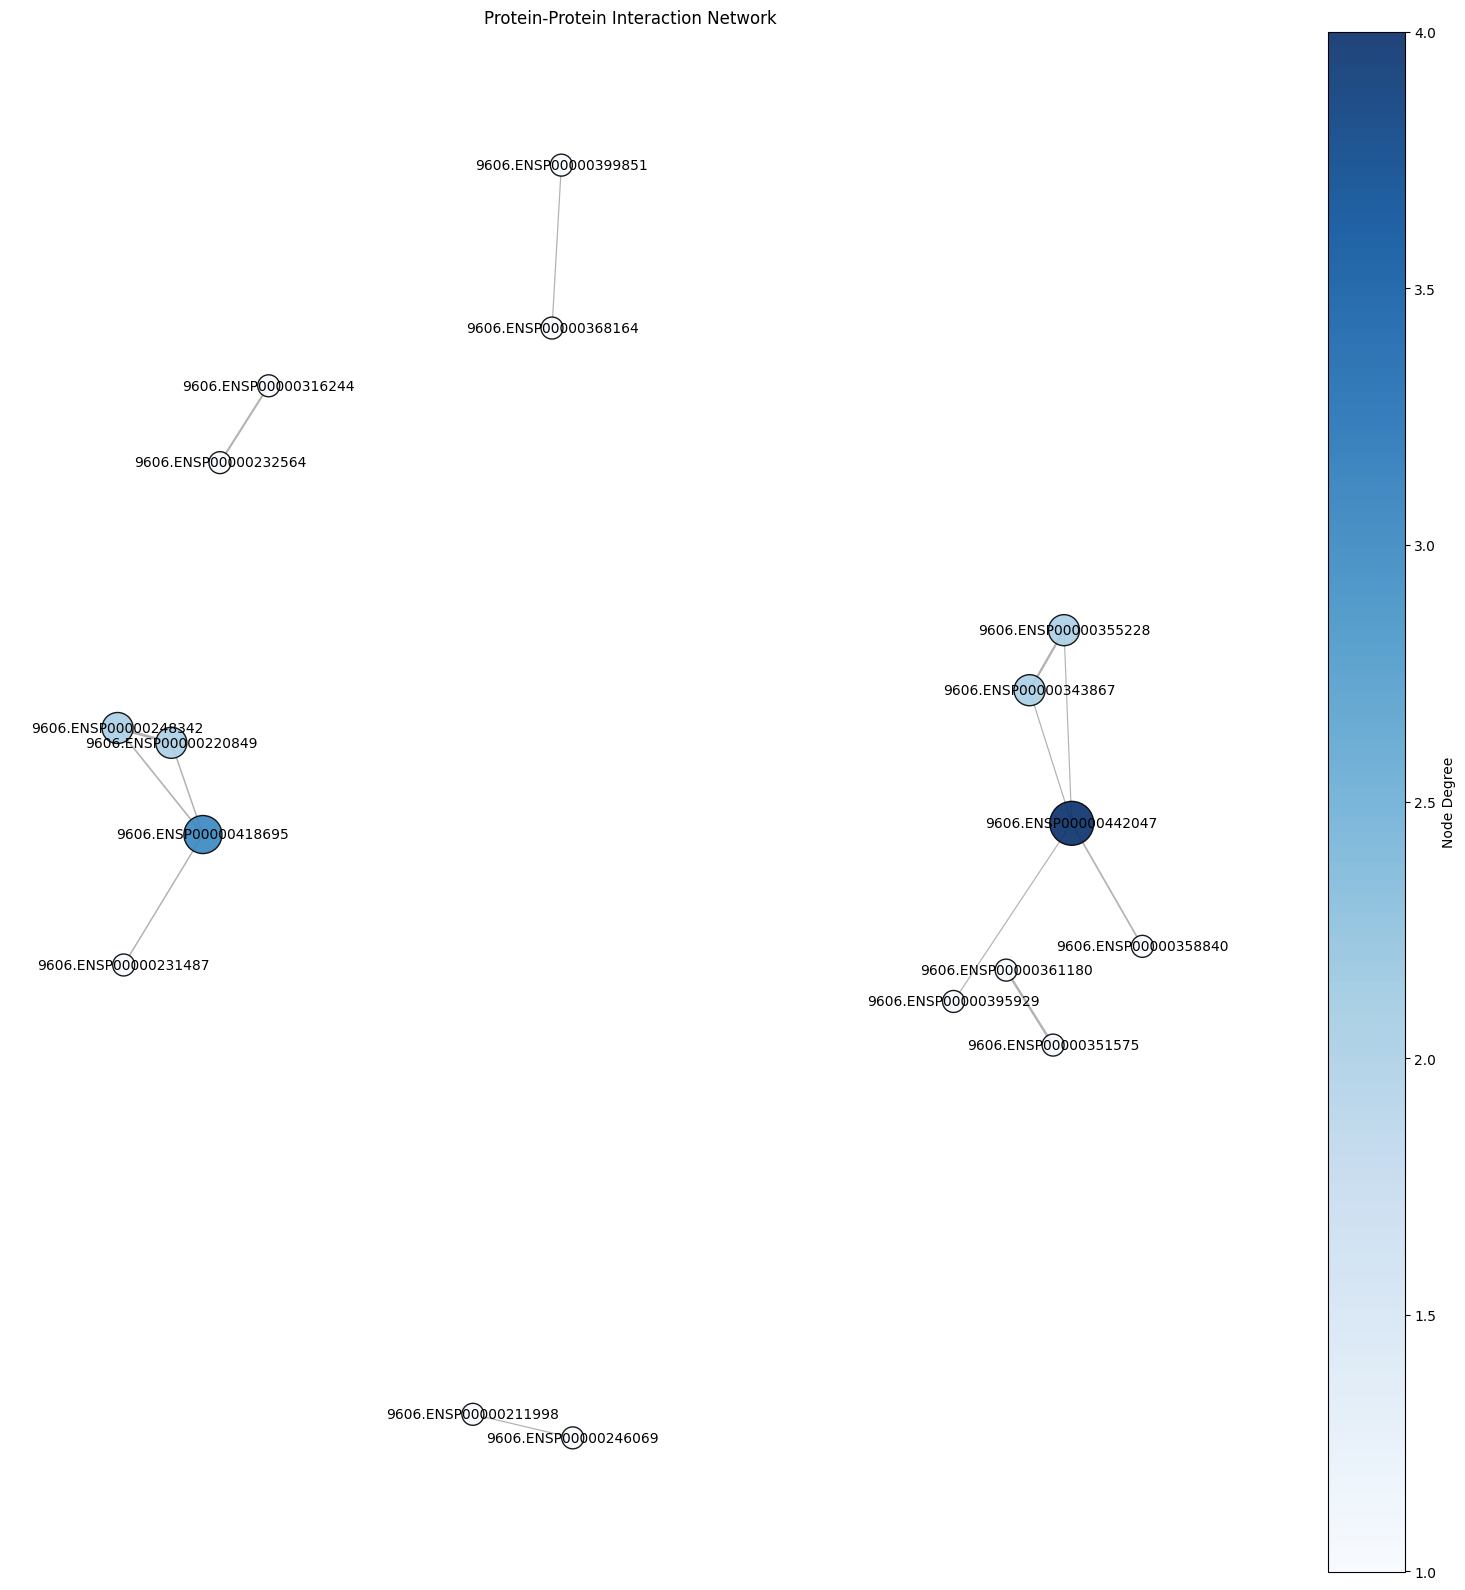

In [ ]:


# Create a networkx graph from the interactions
G = nx.Graph()
G.add_weighted_edges_from(interactions)

# Calculate degrees (number of connections) for node sizing and coloring
degree_dict = dict(G.degree(G.nodes()))
node_size = [v * 250 for v in degree_dict.values()]
node_color = [degree_dict[node] for node in G.nodes()]

# Get edge weights for line thickness
edge_width = [d['weight'] * 2 for (u, v, d) in G.edges(data=True)]

# Plot the network
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, k=0.4)  # k controls the distance between nodes

# Draw nodes with customized size and color
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.Blues, alpha=0.9)
nodes.set_edgecolor('black')  # Outline nodes in black

# Draw edges with customized width
edges = nx.draw_networkx_edges(G, pos, width=edge_width, alpha=0.6, edge_color='grey')

# Draw labels
labels = nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Add color bar for node degree
plt.colorbar(nodes, label='Node Degree')

# Remove axes for better aesthetics
plt.axis('off')
plt.title('Protein-Protein Interaction Network')
plt.show()


# Others


In [ ]:
proteins = data.index.tolist()
proteins = proteins[:50]

NameError: name 'data' is not defined

In [ ]:
# Map proteins to STRING IDs
mapped_proteins = sdb.map_proteins(proteins, "tsv-no-header")
 
# Parse the STRING interactions
interactions = []
for line in mapped_proteins.strip().split("\n"):
    parts = line.split("\t")
    if len(parts) >= 5:
        interactions.append((parts[0], parts[1], float(parts[5])))

mapped_proteins

'9606.ENSP00000217971\t9606.ENSP00000442047\tPGRMC1\tUTY\t9606\t0.422\t0\t0\t0\t0\t0\t0\t0.423\n9606.ENSP00000261574\t9606.ENSP00000370589\tIPO5\tNOP56\t9606\t0.408\t0\t0\t0\t0.378\t0.062\t0\t0.067\n9606.ENSP00000261574\t9606.ENSP00000473383\tIPO5\tFBLL1\t9606\t0.47\t0\t0\t0\t0.341\t0.091\t0\t0.186\n9606.ENSP00000301067\t9606.ENSP00000494040\tKMT2D\tDDX3X\t9606\t0.504\t0\t0\t0\t0.065\t0.051\t0\t0.486\n9606.ENSP00000301067\t9606.ENSP00000442047\tKMT2D\tUTY\t9606\t0.848\t0\t0\t0\t0.073\t0.496\t0.54\t0.378\n9606.ENSP00000342812\t9606.ENSP00000494040\tUSP9Y\tDDX3X\t9606\t0.619\t0\t0\t0\t0.061\t0.126\t0\t0.573\n9606.ENSP00000342812\t9606.ENSP00000442047\tUSP9Y\tUTY\t9606\t0.999\t0\t0\t0\t0.999\t0\t0\t0.983\n9606.ENSP00000356155\t9606.ENSP00000381034\tPIK3C2B\tSOCS6\t9606\t0.57\t0\t0\t0\t0.064\t0\t0.54\t0.083\n9606.ENSP00000370589\t9606.ENSP00000473383\tNOP56\tFBLL1\t9606\t0.994\t0\t0\t0\t0.833\t0.838\t0.54\t0.642\n9606.ENSP00000431800\t9606.ENSP00000448035\tEIF3F\tNACA\t9606\t0.536\t0\t0\t0

In [ ]:
interactions

[('9606.ENSP00000217971', '9606.ENSP00000442047', 0.422),
 ('9606.ENSP00000261574', '9606.ENSP00000370589', 0.408),
 ('9606.ENSP00000261574', '9606.ENSP00000473383', 0.47),
 ('9606.ENSP00000301067', '9606.ENSP00000494040', 0.504),
 ('9606.ENSP00000301067', '9606.ENSP00000442047', 0.848),
 ('9606.ENSP00000342812', '9606.ENSP00000494040', 0.619),
 ('9606.ENSP00000342812', '9606.ENSP00000442047', 0.999),
 ('9606.ENSP00000356155', '9606.ENSP00000381034', 0.57),
 ('9606.ENSP00000370589', '9606.ENSP00000473383', 0.994),
 ('9606.ENSP00000431800', '9606.ENSP00000448035', 0.536),
 ('9606.ENSP00000431800', '9606.ENSP00000494040', 0.651),
 ('9606.ENSP00000442047', '9606.ENSP00000494040', 0.811),
 ('9606.ENSP00000466214', '9606.ENSP00000481842', 0.421)]

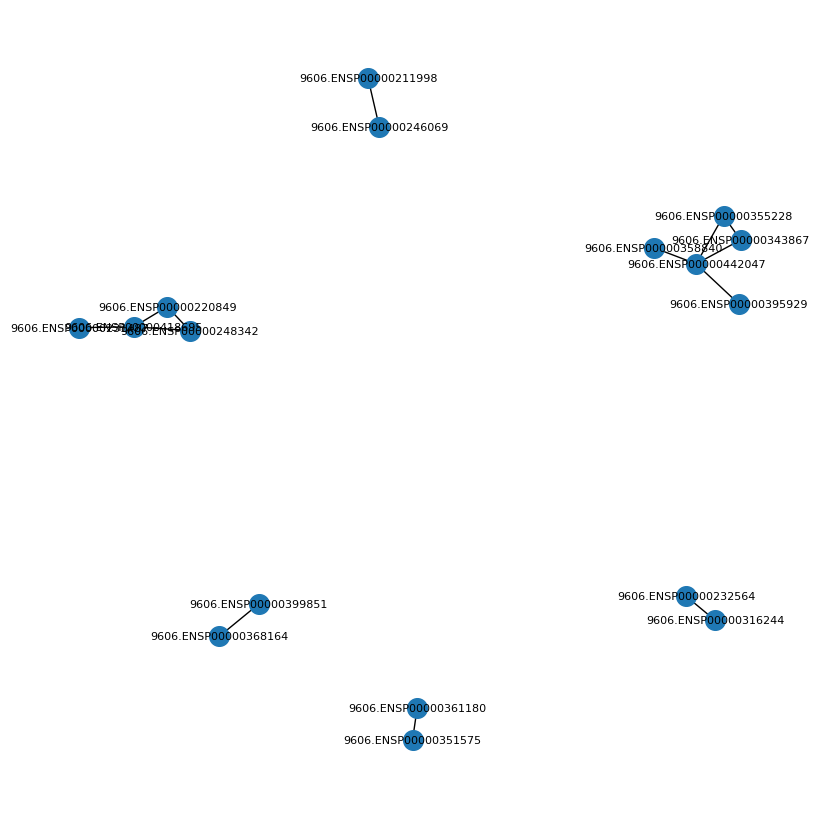

In [ ]:
# Create an networkx object from the interactions
import networkx as nx
G = nx.Graph()
G.add_weighted_edges_from(interactions)


# Plot the network
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=200, width=1)
nx.draw_networkx_labels(G, pos, labels={n: n for n in G.nodes()}, font_size=8)
plt.show()
